In [1]:
import torch
import numpy as np
from sbi.inference import NPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import two_moon_sim
from config import torch_device

c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
simulation_budget=5000
seed=1234
prior=two_moon_sim.prior_torch
x_obs=two_moon_sim.x_o
simulator=two_moon_sim.simulator_torch
num_posterior_samples=1000

In [3]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [4]:
inference = NPE_C(prior=prior, density_estimator="nsf", device=torch_device)

learning_rate = 0.0005  # default value

torch.manual_seed(seed)
np.random.seed(seed)

theta, x = simulate_for_sbi(
    simulator=simulator, proposal=prior, num_simulations=simulation_budget
)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 13729.62it/s]


In [6]:
density_estimator = inference.append_simulations(theta, x).train(
    max_num_epochs=100, learning_rate=learning_rate
)

 Training neural network. Epochs trained: 101

In [7]:
posterior = inference.build_posterior(density_estimator).set_default_x(x_obs)

theta_trained = posterior.sample((num_posterior_samples,), x=x_obs)
theta_trained = theta_trained.reshape((num_posterior_samples, 2))

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(
1098it [00:00, 15359.34it/s]            


In [8]:
theta_trained.shape

torch.Size([1000, 2])

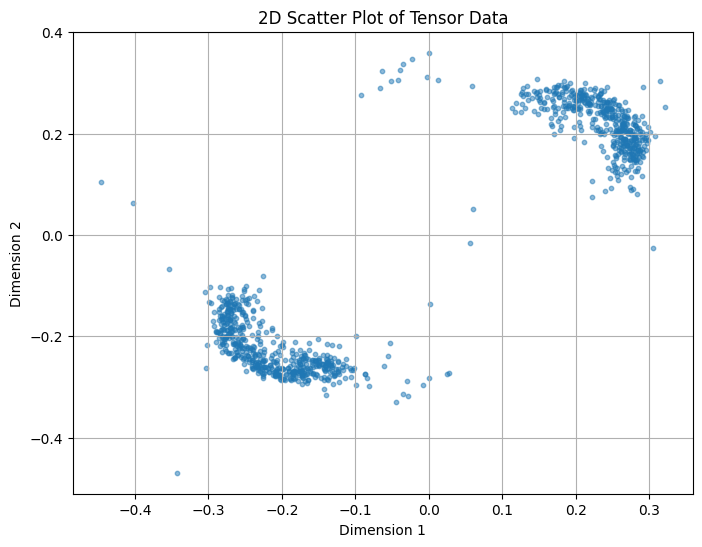

In [11]:
import matplotlib.pyplot as plt

# Assuming your tensor is named 'data'
# Example: data = torch.randn(1000, 2)

# 1. Move to CPU, 2. Detach from graph, 3. Convert to NumPy
data_np = theta_trained.cpu().detach().numpy()

# Extract x and y columns
x = data_np[:, 0]
y = data_np[:, 1]

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, s=10) # alpha for transparency, s for dot size
plt.title("2D Scatter Plot of Tensor Data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()